In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from datetime import datetime
import tf2onnx
import onnx
import onnxruntime as ort
import os
import boto3

2023-11-30 13:27:47.291869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 13:27:48.331773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-30 13:27:48.331848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-30 13:27:48.331858: W tensorfl

In [2]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

X_train = X_train/255
X_test = X_test/255

# Training

Let's train a simple neural network:

In [3]:
model = Sequential()

model.add(Flatten(input_shape=(28,28)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit(X_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2844 - accuracy: 0.9181 - val_loss: 0.1459 - val_accuracy: 0.9571
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1239 - accuracy: 0.9630 - val_loss: 0.1213 - val_accuracy: 0.9628
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0844 - accuracy: 0.9746 - val_loss: 0.1042 - val_accuracy: 0.9709
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0632 - accuracy: 0.9807 - val_loss: 0.0981 - val_accuracy: 0.9710
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0515 - accuracy: 0.9842 - val_loss: 0.0955 - val_accuracy: 0.9727
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0387 - accuracy: 0.9876 - val_loss: 0.1009 - val_accuracy: 0.9730
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 0.1212 - val_accuracy:

In [5]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)
accuracy_score(y_test,y_pred)

313/313 [==============================] - 0s 849us/step


0.9765

# Demo

Let's try out the nn with a small demo, given the following:

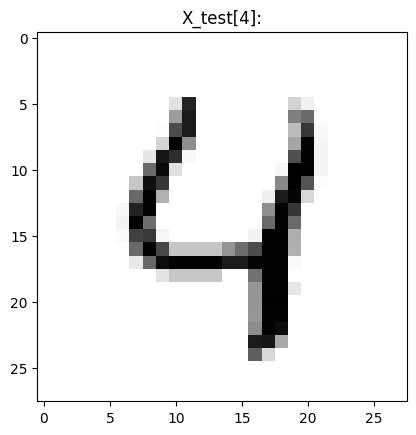

In [6]:
plt.imshow(X_test[4], cmap="Greys")
plt.title('X_test[4]:')
plt.show()

the model predicts it is:

In [7]:
prediction = model.predict(X_test[4].reshape(1,28,28)).argmax(axis=1)[0]
print('prediction: ', prediction)

1/1 [==============================] - 0s 17ms/step
prediction:  4


# Model Save

In [8]:
input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
onnx.save(onnx_model, "model1.onnx")

# Demo using onnx file

In [9]:
model_onnx = onnx.load('model1.onnx')
output = [node.name for node in model_onnx.graph.output]
print(output)

sess = ort.InferenceSession("model1.onnx")
results_ort = sess.run(['dense_2'], {'x': X_test[4].reshape(1,28,28)})
prediction = results_ort[0].argmax(axis=1)[0]
print('prediction: ', prediction)

['dense_2']
prediction:  4


# Store onnx on bucket

In [10]:
registeredmodel_name = "mnist"
version_name = "v1.nb"+datetime.now().strftime("%Y%m%d%H%M%S")
print(f"Will be using: {registeredmodel_name}:{version_name} in the remainder of this task")

s3 = boto3.resource(
    service_name='s3',
    region_name=os.environ['AWS_DEFAULT_REGION'],
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'],
    use_ssl=False,
    endpoint_url=os.environ['AWS_S3_ENDPOINT'],
    verify=False
)

bucket_name = os.environ['AWS_S3_BUCKET']
odh_secret_name = f'aws-connection-{bucket_name}'
in_bucket_path = version_name
in_bucket_target = f'{in_bucket_path}/mnist.onnx'
full_bucket_target = f's3://{bucket_name}/{in_bucket_target}'

my_bucket = s3.Bucket(bucket_name)
my_bucket.upload_file("model1.onnx", in_bucket_target)

print("ls:")
for obj in my_bucket.objects.filter():
    print(obj.key)

Will be using: mnist:v1.nb20231130132831 in the remainder of this task
ls:
artifacts/test-matteo-storesomething-11c33/train-model/outgoingfile.tgz
artifacts/test-matteo-storesomething-11c33/train-model/outgoingfile2.tgz
artifacts/test-matteo-storesomething-11c33/validate-model/Output.tgz
experiment1/mnist.onnx
pipelines/91c05d13-7a85-4133-844e-889c3a00999c
pipelines/db1f4601-8c10-4379-8a22-09a49faa66e5
v1.nb20231130105804/mnist.onnx
v1.nb20231130105849/mnist.onnx
v1.nb20231130110240/mnist.onnx
v1.nb20231130110352/mnist.onnx
v1.nb20231130132831/mnist.onnx
v2.nb20231130132332/mnist.onnx
v20231128110416/mnist.onnx


# Register model on Model Registry

In [11]:
from model_registry import ModelRegistry

registry = ModelRegistry(server_address="modelregistry-sample", port=9090, author="author")

model = registry.register_model(registeredmodel_name,
                                full_bucket_target,
                                model_format_name="onnx",
                                model_format_version="1",
                                storage_key=odh_secret_name,
                                storage_path=in_bucket_path,
                                version=version_name,
                                description="demo20231121 e2e MNIST",
                                )
print("RegisteredModel:")
print(registry.get_registered_model(registeredmodel_name))
print("ModelVersion:")
print(registry.get_model_version(registeredmodel_name, version_name))
print("ModelArtifact:")
print(registry.get_model_artifact(registeredmodel_name, version_name))

RegisteredModel:
RegisteredModel(id='2', description='', external_id='', create_time_since_epoch=1701169456901, last_update_time_since_epoch=1701169456901, name='mnist')
ModelVersion:
ModelVersion(name='v1.nb20231130132831', id='13', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1701350912964, last_update_time_since_epoch=1701350912964, model_name='mnist', version='v1.nb20231130132831', author='author', artifacts=NOTHING, tags=[], metadata={}, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='7', description='', external_id='', create_time_since_epoch=1701350914796, last_update_time_since_epoch=1701350914796, name='mnist', uri='s3://mybucket/v1.nb20231130132831/mnist.onnx', state=<ArtifactState.UNKNOWN: 0>, model_format_name='onnx', model_format_version='1', storage_key='aws-connection-mybucket', storage_path='v1.nb20231130132831', service_account_name='', _model_version_id=NOTHING)
